Nilesh Aapparao Kale [AI3005]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
zip_path = '/content/drive/MyDrive/DL Dataset/gwbz3fsgp8-2.zip'
extract_path = '/content/ecg_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
!pip install -q tensorflow


In [ ]:
import os

base_path = extract_path

rename_map = {
    'ECG Images of Myocardial Infarction Patients (240x12=2880)': 'Myocardial_Infarction',
    'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 'Abnormal_Heartbeat',
    'ECG Images of Patient that have History of MI (172x12=2064)': 'History_of_MI',
    'Normal Person ECG Images (284x12=3408)': 'Normal'
}

for old_name, new_name in rename_map.items():
    old_path = os.path.join(base_path, old_name)
    new_path = os.path.join(base_path, new_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed {old_name} -> {new_name}")


Renamed ECG Images of Myocardial Infarction Patients (240x12=2880) -> Myocardial_Infarction
Renamed ECG Images of Patient that have abnormal heartbeat (233x12=2796) -> Abnormal_Heartbeat
Renamed ECG Images of Patient that have History of MI (172x12=2064) -> History_of_MI
Renamed Normal Person ECG Images (284x12=3408) -> Normal


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
data_dir = "/content/ecg_dataset"

# Image Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

img_size = (224, 224)
batch_size = 32

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)


Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.
Classes: ['Abnormal_Heartbeat', 'History_of_MI', 'Myocardial_Infarction', 'Normal']


In [ ]:
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(zip(np.unique(labels), class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {np.int32(0): np.float64(0.9959893048128342), np.int32(1): np.float64(1.3496376811594204), np.int32(2): np.float64(0.9700520833333334), np.int32(3): np.float64(0.8168859649122807)}


In [ ]:
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # freeze initial layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,827,588 (90.90 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
✅ Validation Accuracy: 89.07%
                       precision    recall  f1-score   support

   Abnormal_Heartbeat       0.91      0.89      0.90        46
        History_of_MI       0.86      0.71      0.77        34
Myocardial_Infarction       0.89      1.00      0.94        47
               Normal       0.89      0.91      0.90        56

             accuracy                           0.89       183
            macro avg       0.89      0.88      0.88       183
         weighted avg       0.89      0.89      0.89       183



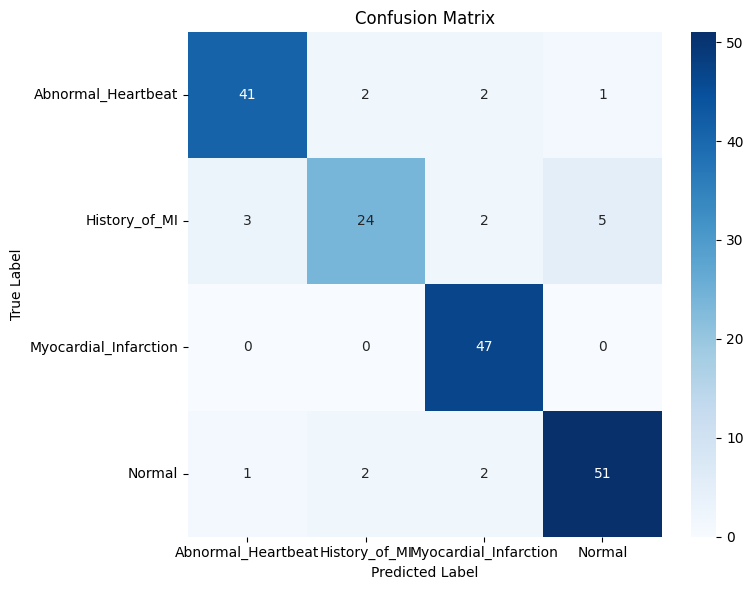

In [ ]:
# Predict on validation set
val_gen.reset()
pred_probs = model.predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes

# Print validation accuracy
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(true_classes, pred_classes)
print(f"✅ Validation Accuracy: {val_accuracy * 100:.2f}%")

# Classification report
report = classification_report(true_classes, pred_classes, target_names=class_names)
print(report)

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
model.save('ecg_resnet_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


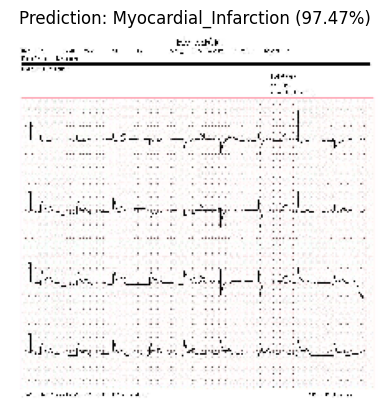

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load model and class names
model = load_model('/content/ecg_resnet_model.h5')
class_names = ['Abnormal_Heartbeat', 'History_of_MI', 'Myocardial_Infarction', 'Normal']

# Load and preprocess the image
img_path = '/content/MI(3).jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]
confidence = np.max(predictions) * 100

# Show result
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
plt.show()
